In [1]:
import velvet as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
import torchsde
import matplotlib.cm as cm

In [4]:
nmp = sc.read_h5ad('../data/nmp_data_1606.h5ad')
nmp

AnnData object with n_obs × n_vars = 24262 × 1229
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'sample', 'timepoint', 'rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label_rate', 'doublet_score', 'marker_based_classification', 'cell_annotation', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors'
    obsm: 'Ts', 'X_z', 'knn_index', 'velocity_z'
    layers: 'new', 'old', 'total'
    obsp: 'connectivities', 'distances'

INFO     Generating sequential column names                                                                        
Wrapper for velocity pseudotime calculated by scVelo.
Authors: Volker Bergen, Marius Lange, Stefan Peidli, F. Alexander Wolf & Fabian J. Theis
Paper: https://www.nature.com/articles/s41587-020-0591-3
computing velocity graph (using 1/80 cores)


  0%|          | 0/24262 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 4 regions of root cells and 2 regions of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


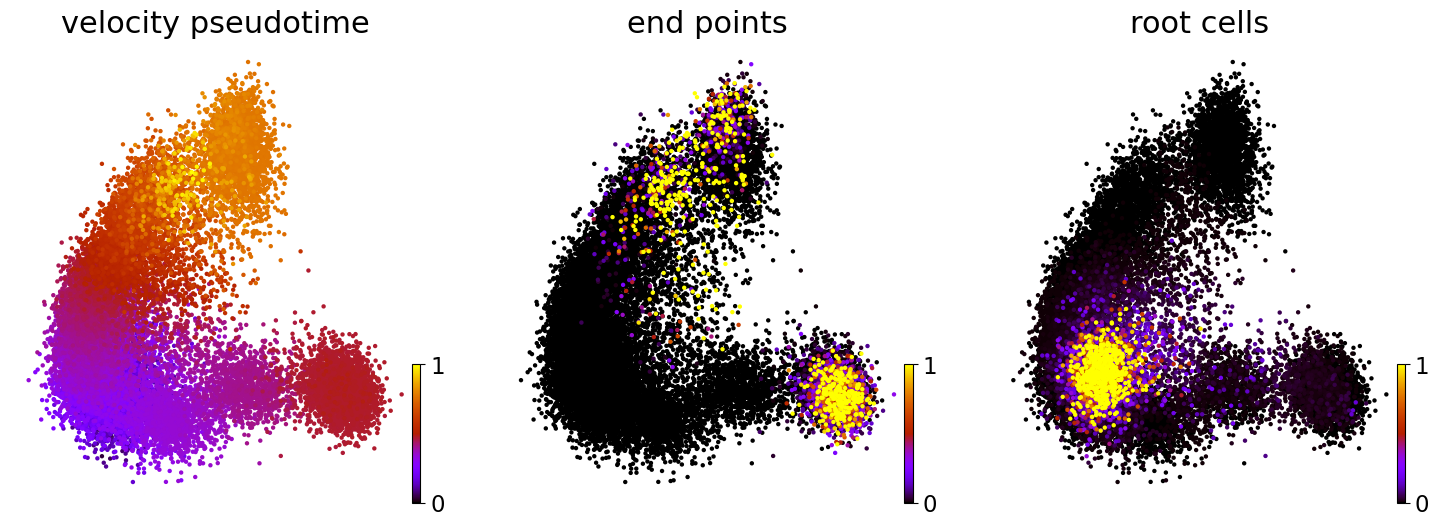

KNN indices for Velvet stored in .obsm['knn_index'].


<All keys matched successfully>

In [5]:
state_path = '../models/nmp_vf_1606_model.pt'

vt.md.Velvet.setup_anndata(nmp, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    nmp,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)
model.module = model.module.to('cuda')

model.infer_pseudotime()

## SDE
model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    t_key='t',
    index_key='index'
)

markov = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True,
    use_similarity=False
)

sde = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.1,
    device=model.device
)

sde_model = vt.sm.VelvetSDE(
    model,
    sde,
    markov,
)

sde_state_path = '../models/nmp_sde_1606_model.pt'

trained_state_sde = torch.load(sde_state_path)['model_state_dict']

sde_model.module.load_state_dict(trained_state_sde)

In [6]:
sde_untrained = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.1,
    device=model.device
)


vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    t_key='t',
    index_key='index'
)

sde_model_untrained = vt.sm.VelvetSDE(
    model,
    sde_untrained,
    markov,
)

In [7]:
n_trajectories = 2000
n_steps = 200
t_max = 80
dt = 1.0
beginning_pct = 10
components=[0,1]
one_color=False
alpha=0.2

z = sde_model.adata.obsm['X_z']
z = torch.tensor(z, device=sde_model.device)

t = torch.tensor(
    sde_model.adata.obs.t,
    device=sde_model.device
).squeeze()

time_index = torch.argsort(t)

z_sorted = z[time_index,:]
t_sorted = t[time_index]

valid_indices = int((beginning_pct/100)*z.shape[0])
cell_indices = torch.randperm(valid_indices)[:n_trajectories]

initial_cells = z_sorted[cell_indices,:]
timespan = torch.linspace(0, t_max, n_steps, device=sde_model.device)

pre_trajectories = torchsde.sdeint_adjoint(
    sde_model_untrained.module.sde,
    initial_cells,
    timespan,
    method="midpoint",
    dt=dt
)

post_trajectories = torchsde.sdeint_adjoint(
    sde_model.module.sde,
    initial_cells,
    timespan,
    method="midpoint",
    dt=dt
)

In [8]:
X = torch.tensor(model.adata.obsm['X_z'], device=model.device)
Y_pre = pre_trajectories.reshape(-1,50)
Y_post = post_trajectories.reshape(-1,50)

X_mu, X_std =  X.mean(0), X.std(0)
Y_pre_mu, Y_pre_std =  Y_pre.mean(0), Y_pre.std(0)
Y_post_mu, Y_post_std =  Y_post.mean(0), Y_post.std(0)

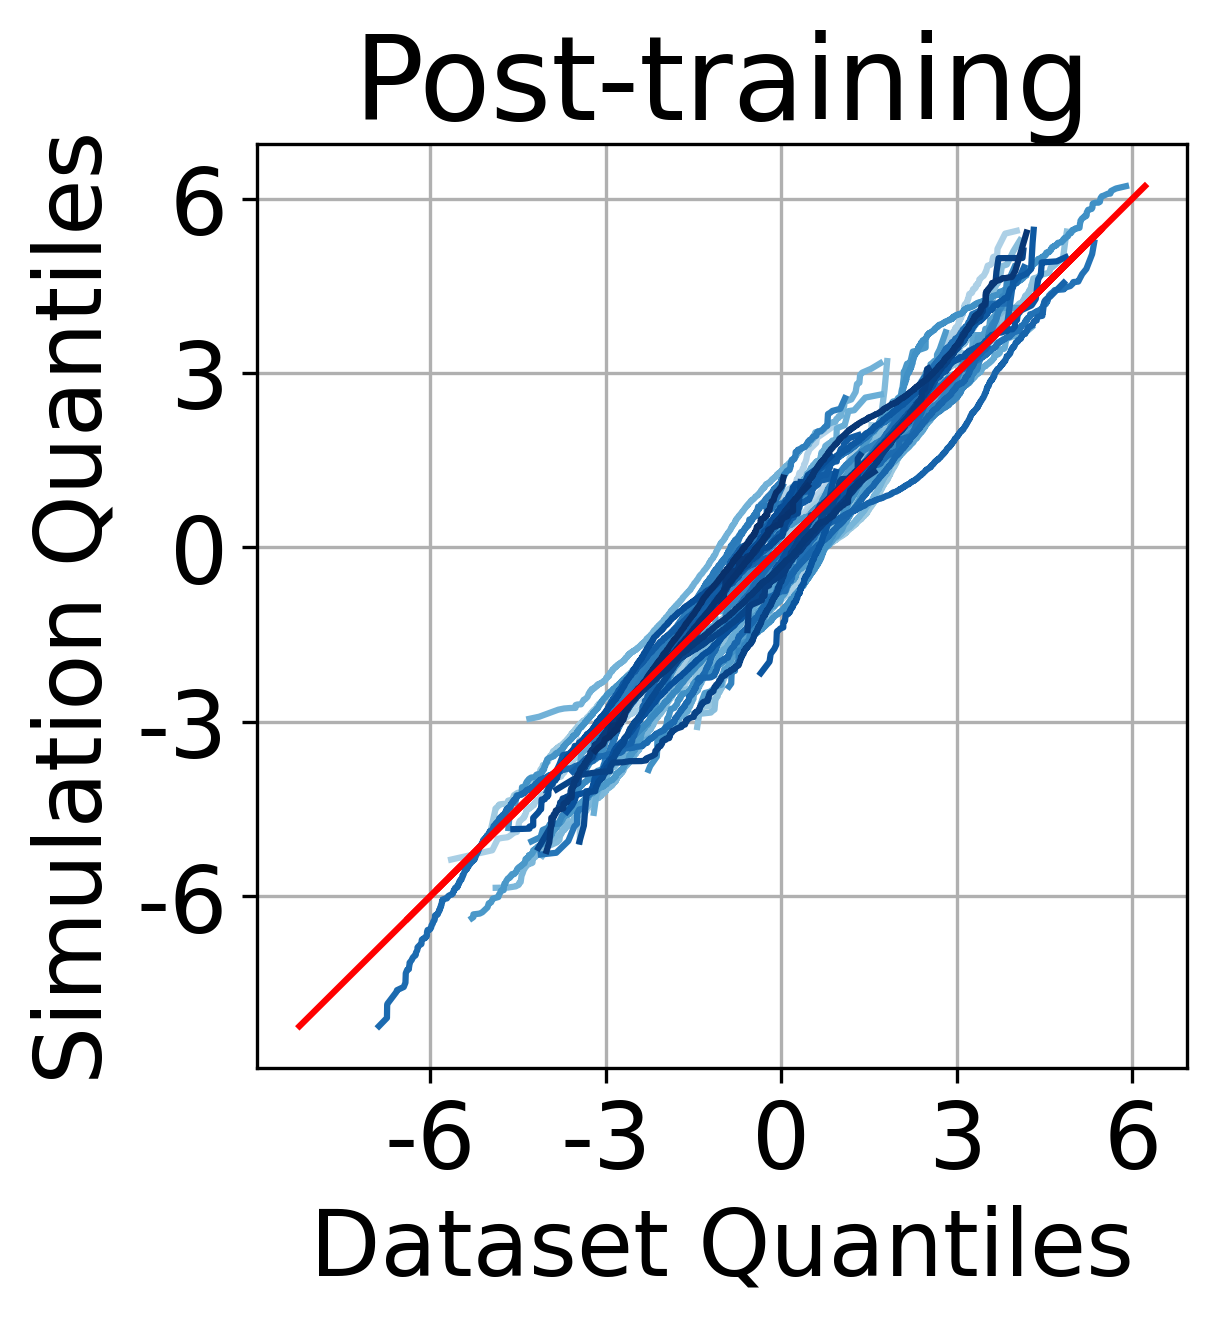

In [10]:
plt.figure(figsize=(4, 4), dpi=300)
colors = cm.Blues(np.linspace(0.3, 1, 50))

for i in range(50):
    x = np.random.choice(X[:,i].detach().cpu().numpy(), size=5000)
    y = np.random.choice(Y_post[:,i].detach().cpu().numpy(), size=5000)

    # Sort the arrays
    x = np.sort(x)
    y = np.sort(y)

    # Create quantiles
    quantiles = np.linspace(start=0, stop=1, num=min(len(x), len(y)))

    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Create Q-Q plot
    plt.plot(x_quantiles, y_quantiles, color=colors[i])
    plt.plot([np.min((x_quantiles.min(),y_quantiles.min())), np.max((x_quantiles.max(),y_quantiles.max()))], 
             [np.min((x_quantiles.min(),y_quantiles.min())), np.max((x_quantiles.max(),y_quantiles.max()))], 
             color='r')

plt.title('Post-training', fontsize=28)
plt.xlabel('Dataset Quantiles', fontsize=22)
plt.ylabel('Simulation Quantiles', fontsize=22)
plt.xticks([-6,-3,0,3,6],[-6,-3,0,3,6],fontsize=22)
plt.yticks([-6,-3,0,3,6],[-6,-3,0,3,6],fontsize=22)
plt.grid(True)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/2.6.0_qqplot_post.png', bbox_inches='tight')
plt.show()

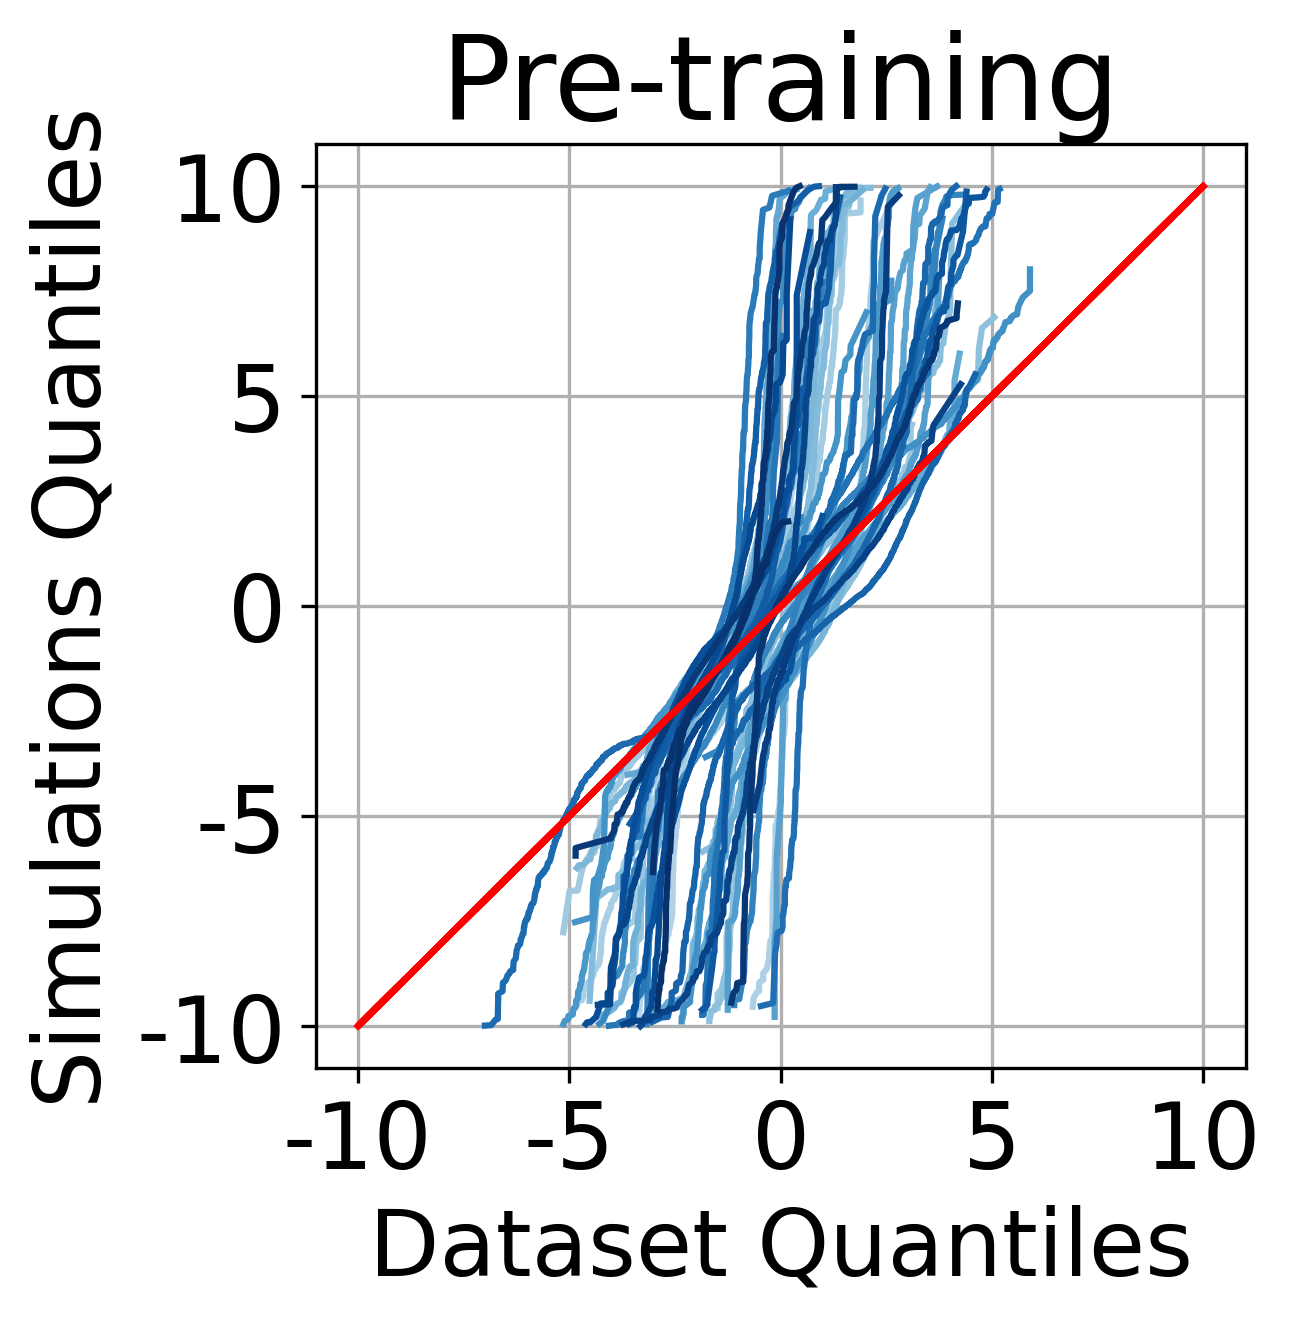

In [11]:
plt.figure(figsize=(4, 4), dpi=300)
colors = cm.Blues(np.linspace(0.3, 1, 50))

for i in range(50):
    x = np.random.choice(X[:,i].detach().cpu().numpy(), size=5000)
    yp = Y_pre[:,i].detach().cpu().numpy()
    yp = yp[(yp>-10)&(yp<10)]
    y = np.random.choice(yp, size=5000)
    # Sort the arrays
    x = np.sort(x)
    y = np.sort(y)

    # Create quantiles
    quantiles = np.linspace(start=0, stop=1, num=min(len(x), len(y)))

    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Create Q-Q plot
    plt.plot(x_quantiles, y_quantiles, color=colors[i])
    plt.plot([np.min((x_quantiles.min(),y_quantiles.min())), np.max((x_quantiles.max(),y_quantiles.max()))], 
             [np.min((x_quantiles.min(),y_quantiles.min())), np.max((x_quantiles.max(),y_quantiles.max()))], 
             color='r')

plt.title('Pre-training', fontsize=28)
plt.xlabel('Dataset Quantiles', fontsize=22)
plt.ylabel('Simulations Quantiles', fontsize=22)
plt.xticks([-10,-5,0,5,10],[-10,-5,0,5,10],fontsize=22)
plt.yticks([-10,-5,0,5,10],[-10,-5,0,5,10],fontsize=22)
plt.grid(True)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/2.6.1_qqplot_pre.png', bbox_inches='tight')
plt.show()

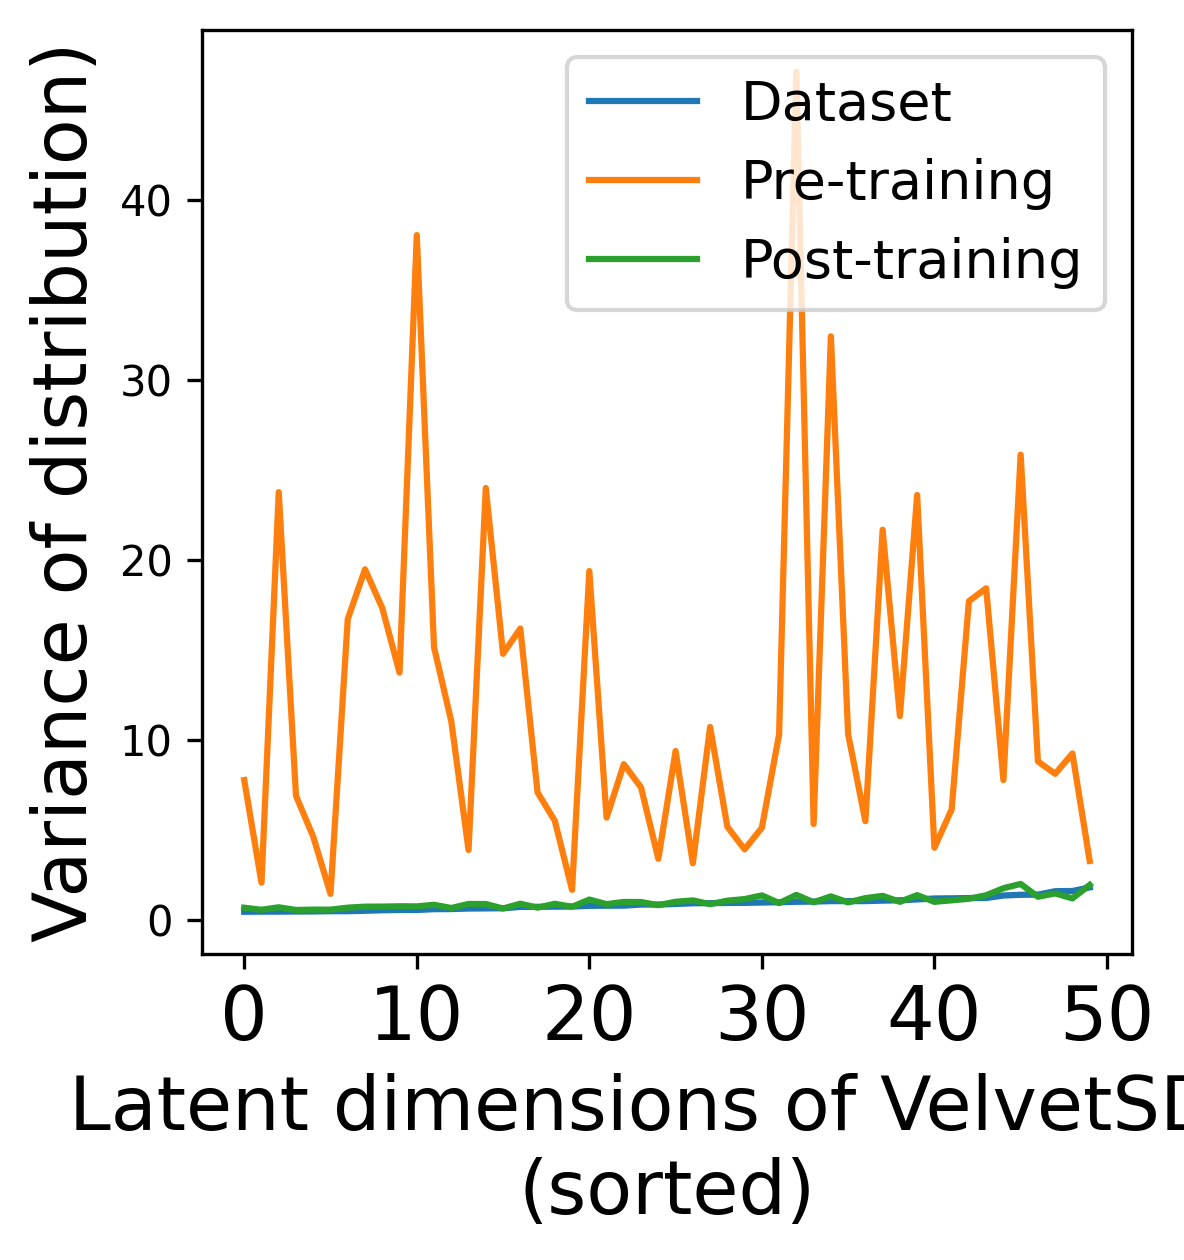

In [13]:
plt.figure(figsize=(4,4), dpi=300)

idx = np.argsort(X_std.detach().cpu().numpy())
plt.plot(X_std[idx].detach().cpu().numpy(), label='Dataset')
plt.plot(Y_pre_std[idx].detach().cpu().numpy(), label='Pre-training')
plt.plot(Y_post_std[idx].detach().cpu().numpy(), label='Post-training')
plt.legend(fontsize=13)
plt.xlabel("Latent dimensions of VelvetSDE\n(sorted)", fontsize=18)
plt.ylabel("Variance of distribution)", fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(fontsize=18)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/2.6.2_training_variances.png', bbox_inches='tight')
plt.show()

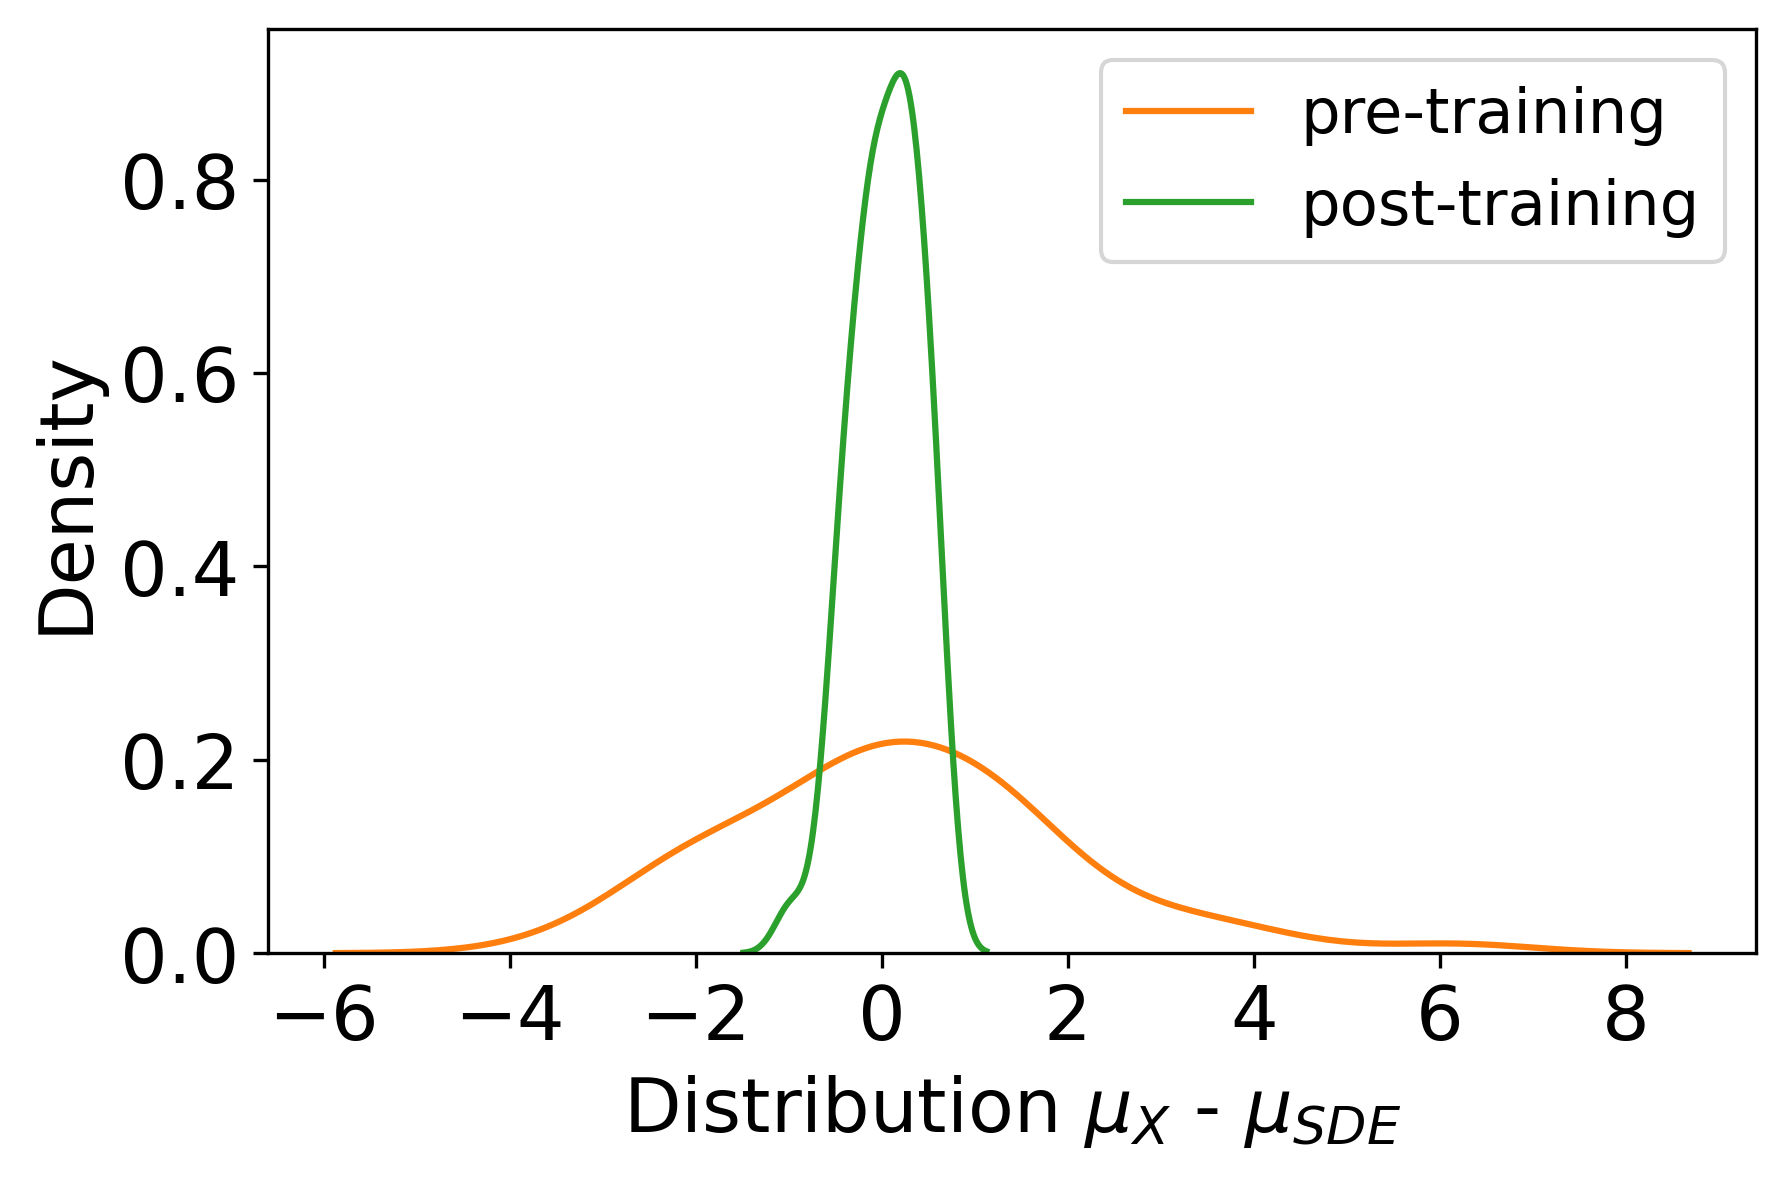

In [15]:
plt.figure(figsize=(6.4,4),dpi=300)
sns.kdeplot(((X_mu - Y_pre_mu)).detach().cpu().numpy(), color='tab:orange', label='pre-training')
sns.kdeplot(((X_mu - Y_post_mu)).detach().cpu().numpy(), color='tab:green', label='post-training')
plt.xlabel(r"Distribution $\mu_X$ - $\mu_{SDE}$", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/2.6.3_training_difference_mus.png', bbox_inches='tight')
plt.show()